<a href="https://colab.research.google.com/github/sajidkhan2067/DDoSAttackDetectionUsingCNN/blob/main/CNN_Binary_Classifier_Container.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required modules.

In [ ]:
from datetime import datetime as dt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import ipaddress
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn import metrics


In [ ]:
from keras.models import Sequential, load_model
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
# # number of benign traffic row = 2*number_of_samples
# number_of_samples = 100000
# # number of attack traffic row = number_of_samples_attack
# number_of_samples_attack =100000

In [ ]:
# First, we get the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Number of features

In [ ]:
features = ['Flow Duration', 'Fwd Packet Length Std', 'ACK Flag Count', 'Protocol', 'Total Fwd Packet', 'Total Bwd packets',
    'Total Length of Fwd Packet', 'Total Length of Bwd Packet','Label']
featuresWithoutLabel = ['Flow Duration', 'Fwd Packet Length Std', 'ACK Flag Count', 'Protocol', 'Total Fwd Packet', 'Total Bwd packets',
    'Total Length of Fwd Packet', 'Total Length of Bwd Packet']

# Read data from attack and normal datasets.

In [ ]:
dataset_sources = {
    'attack': {
        'path': '/content/drive/MyDrive/Colab Notebooks/LSTM/New_CiCflowmeter/ConTainerTB/Attack'
    },
     'benign': {
        'path': '/content/drive/MyDrive/Colab Notebooks/LSTM/New_CiCflowmeter/ConTainerTB/Benign'
     },
}

In [ ]:
import os
# Helper function to read CSV files form a given directory
# directory_path: Directory where csv files located
# limit: limit the sample based on parameter set while calling the function

def read_all_csv_files(directory_path, features, limit=1000000):
    # Initialize an empty list to store dataframes from CSV files
    dataframes = []

    # Get a list of all files in the directory
    file_list = os.listdir(directory_path)

    # Loop through each file and check if it's a CSV file
    for file_name in file_list:
        if file_name.endswith('.csv'):
            # Get the full file path
            file_path = os.path.join(directory_path, file_name)
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)
            # Remove leading and trailing spaces from column names
            df.columns = df.columns.str.strip()
            # Append the DataFrame to the list
            dataframes.append(df[features])

    # Merge all DataFrames into a single DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)
    print("Initial Row: {}".format(merged_df.shape[0]))

        #applying limit if row_count > limit
    if len(merged_df) > limit:
        print("As Row Exceeds {0}, we are taking upto {1} rows".format(limit, limit))
        merged_df = merged_df.sample(limit) #set the random_sate so that everytime this will pull the same random numbers

    return merged_df

In [ ]:
# Sanitize teh data frame
# Remove null values
# Remove infinte values

def sanitize_data_frames_updated(dataframe, limit=1000000, remove_infinity=True, remove_null=True):
    print("Before Santization Row Count:", dataframe.shape[0])

    if remove_infinity:
        numeric_cols = dataframe.select_dtypes(include=[np.number]).columns
        infinite_counts = dataframe[numeric_cols].applymap(np.isinf).sum()
        for col, count in infinite_counts.items():
            if count != 0:
                print(f"Column '{col}' contains {count} infinite values.")
                if limit is not None:
                    dataframe = dataframe[~np.isinf(dataframe[col])]

    if remove_null:
        null_counts = dataframe.isnull().sum()
        for col, count in null_counts.items():
            if count != 0:
                print(f"Column '{col}' contains {count} null values.")
                if limit is not None:
                    dataframe = dataframe.dropna(subset=[col])

    print("Sanitized Row Count:", dataframe.shape[0])
    return dataframe


In [ ]:
# Read the data
from tqdm import tqdm
for key, element in tqdm(dataset_sources.items(), total=len(dataset_sources)):
    print("Loading.....{0}.......".format(key))
    directory_path = element['path']
    print("Directory: {0}".format(directory_path))
    dataframe = read_all_csv_files(directory_path, features)
    dataframe = sanitize_data_frames_updated(dataframe)
    #print(dataframe.describe())
    locals()[key] = dataframe
    dataframe.describe()
    print("END.....{0}.......".format(key))
    print("\n\n")

  0%|          | 0/2 [00:00<?, ?it/s]

Loading.....attack.......
Directory: /content/drive/MyDrive/Colab Notebooks/LSTM/New_CiCflowmeter/ConTainerTB/Attack
Initial Row: 5481810
As Row Exceeds 1000000, we are taking upto 1000000 rows
Before Santization Row Count: 1000000
Sanitized Row Count: 1000000


 50%|█████     | 1/2 [01:55<01:55, 115.43s/it]

END.....attack.......



Loading.....benign.......
Directory: /content/drive/MyDrive/Colab Notebooks/LSTM/New_CiCflowmeter/ConTainerTB/Benign
Initial Row: 689505
Before Santization Row Count: 689505
Sanitized Row Count: 689505


100%|██████████| 2/2 [02:19<00:00, 69.88s/it]

END.....benign.......





In [ ]:
for key, element in dataset_sources.items():
    print('{0}: {1}'.format(key, locals()[key].shape))
    if "{0}".format(key) == "attack":
      dfAttack = locals()[key]
    elif "{0}".format(key) == "benign":
      dfBenign = locals()[key]
    print("{0}".format(key))
    print(locals()[key].shape[0])


print(dfAttack.shape)
print(dfBenign.shape)

attack: (1000000, 9)
attack
1000000
benign: (689505, 9)
benign
689505
(1000000, 9)
(689505, 9)


In [ ]:
default_value = 'attack'
dfAttack = dfAttack.assign(Label=default_value)



In [ ]:
default_value = 'Benign'
dfBenign = dfBenign.assign(Label=default_value)


In [ ]:
print(dfBenign.shape)
print(dfAttack.shape)

(689505, 9)
(1000000, 9)


**Various shapes are showing from different data frames**

In [ ]:
dfAttack=dfAttack.sample(n=dfBenign.shape[0])
print(dfAttack.shape)
print(dfBenign.shape)

Y_normal = pd.concat([pd.DataFrame(dfBenign['Label'])], axis=0)
# Y_normal=Y_normal.sample(n=number_of_samples_attack)

Y_attack= pd.concat([pd.DataFrame(dfAttack['Label'])], axis=0)
# Y_attack=Y_attack.sample(n=Y_normal.shape[0],replace=True)

X_normal = pd.concat([pd.DataFrame(dfBenign[featuresWithoutLabel].values)], axis=0)

X_attack = pd.concat([pd.DataFrame(dfAttack[featuresWithoutLabel].values)], axis=0)


X=np.concatenate((X_normal,X_attack))


print(X.shape)
print(X[0].shape)
print(len(X))
print(len(X_normal))
print(len(X_attack))

print(len(Y_normal))
print(len(Y_attack))

Y_attack=Y_attack.values.flatten()
Y_normal=Y_normal.values.flatten()


Y=np.concatenate((Y_normal,Y_attack))



(689505, 9)
(689505, 9)
(1379010, 8)
(8,)
1379010
689505
689505
689505
689505


# Standardise the data

In [ ]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)
print(X[0:5])
print(X.shape)

[[-0.48232136  0.11080572 -0.00329747 -0.27218613 -0.00396986 -0.00431188
  -0.0342531  -0.0049823 ]
 [-0.48427226  0.62078238 -0.00377456 -0.27218613 -0.00445065 -0.00478556
  -0.03734249 -0.00476571]
 [-0.48727732 -0.63458491 -0.00616001 -0.27218613 -0.00877773 -0.00636446
  -0.09104349 -0.00569176]
 [-0.4842515   0.7482598  -0.00425165 -0.27218613 -0.00541222 -0.00510134
  -0.03734249 -0.00500424]
 [-0.48727505 -0.63458491 -0.00616001 -0.27218613 -0.00877773 -0.00636446
  -0.09104349 -0.00569176]]
(1379010, 8)


# The class field, replace value 'attack' with 0 and 'normal' with 1

In [ ]:
for i in range(0,len(Y)):
  # print(Y[i])
  if Y[i] =="attack":
    Y[i]=0
  else:
    Y[i]=1



In [ ]:
# I = np.expand_dims(X, -1)
#reshape data to fit model
X= X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
print(X[198:199])
print(X.shape)



[[[-0.4872743 ]
  [-0.63458491]
  [-0.00616001]
  [-0.27218613]
  [-0.00877773]
  [-0.00636446]
  [-0.09104349]
  [-0.00569176]]]
(1379010, 8, 1)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
print(X.shape)
# print(I.shape)
print(X_train.shape)
print(X_test.shape)
print(" ")
print(Y_train.shape)
print(Y_test.shape)

(1379010, 8, 1)
(1103208, 8, 1)
(275802, 8, 1)
 
(1103208,)
(275802,)


The architecture of the model

In [ ]:
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

def create_baseline():
    model = Sequential()
#
   #add model layers
    model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(len(featuresWithoutLabel),1)))
    model.add(Conv1D(32, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [ ]:
model = create_baseline()
# print(Y_train[1000:len(Y_train)])


# Saving and loading model

In [ ]:
from keras.callbacks import EarlyStopping
import time
# print(X_train)

Y_train=Y_train.astype(float)
# print(Y_train)
start_time = time.time()

model_path = "/content/drive/MyDrive/MLModel/cnn_container_model.keras"
history=None

try:
  model = load_model(model_path)
  # history = model.history()
  print("Model loaded successfully from", model_path)
except:
  history = model.fit(X_train, Y_train, epochs=60,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
  model.save(model_path)
  print("Model saved to", model_path)

print(model.summary())

Model loaded successfully from /content/drive/MyDrive/MLModel/cnn_container_model.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 64)             192       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 32)             4128      
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 1)                 193       
                                                                 
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________
None


#Prediction

In [ ]:
predict = model.predict(X_test, verbose=1)

8619/8619 [==============================] - 19s 2ms/step


#  Calculate True positive,True negetive,False positive and False negetive values. Then, Create Heatmap with all those values.

In [ ]:
tp = 1
tn = 1
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1

#Printing and calculating various values

print('tp:',tp)
print('fn:',fn)
print('fp:',fp)
print('tn:',tn)
accuracy = (tp+tn)/(tp+tn+fn+fp)
print('Accuracy:',accuracy)
recall = tp/(tp+fn)
print('Recall:',recall)
precision = tp/(tp+fp)
print('Precision:',precision)
f1_score = 2*((precision*recall)/(precision+recall))
print('F1 score: %f' % f1_score)
FPR = fp/(fp + tn)
print('FPR:' ,FPR)
FNR = fn / (fn + tp)
print('FNR:' ,FNR)
far = (FPR+FNR)/2
print('far:' ,far)


# mean_squared_error(Y_testn,predictn)
MSE = np.square(np.subtract(Y_testn,predictn)).mean()
print(MSE)
auc = metrics.roc_auc_score(Y_testn, predictn)

#print AUC score
print(auc)
# from sklearn.metrics import mean_squared_error
# print(Y_testn[0:10])
# print(predictn[0:10])
# mse = tf.keras.losses.MeanSquaredError()
# loss = mse(Y_testn,predictn)
# print('Loss: ', loss.numpy())  # Loss: 0.75
# mean_squared_error(Y_testn, predictn)
# print(mean_squared_error)

tp: 137958
fn: 2
fp: 100
tn: 137744
Accuracy: 0.9996301721512378
Recall: 0.9999855030443607
Precision: 0.9992756667487578
F1 score: 0.999630
FPR: 0.0007254577638489887
FNR: 1.4496955639315744e-05
far: 0.00036997735974415223
0.0003698305305980377
0.9996305709594226


# Heatmap

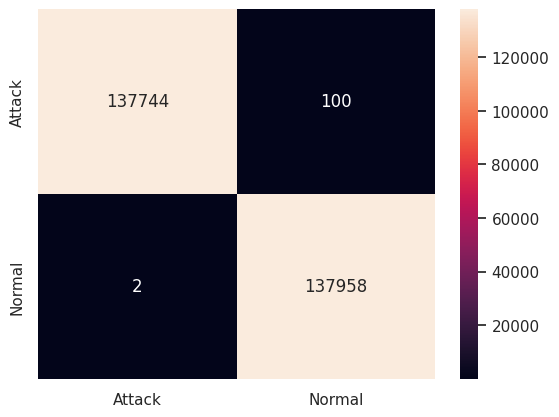

In [ ]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

# Save details

In [ ]:
Y_test=Y_test.astype(float)
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.96%
